# Training and evaluating the Convolutional Vgg models (A,B)

In [1]:
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense, Activation, BatchNormalization, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Flatten
import numpy as np
import scipy as sp
from skimage import color
import warnings
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import pandas as pd

# Import own .py files
import data_collector
import image_loader
import nnetwork
from nnetwork import weighted_categorical_crossentropy
from utility_methods import save_plots
from importlib import reload  # Python 3.4+ only.
nnetwork = reload(nnetwork)
import gc

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
O:\ProgrammingSoftwares\anaconda_projects\dp_nagyhazi\src\utility_methods.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by th

### Starting info

I started from this paper: <b>Colorful image colorization - Richard Zhang, Phillip Isola, Alexei A. Efros</b>
https://arxiv.org/pdf/1603.08511.pdf

In short they found out, that image colorization problem considered as a multinomial classification problem give better results than the other older solutions for this problem. Because of that, they first turned the RGB pixels into LAB colorspace. In this colorspace, the colorisation problem can be interpreted as input = L, output = a,b.  
First they created an RGB distribution ->  RGB(a,b|L = 50)
![RGB distribution](img_for_description/rgb_distribution.png)  
  
After that they discretize the values, with this method they got 313 class which are different pixels. This discretized list is saved to numpy pts_hull_file, it is a 2 dimensional with shape of (313,2) where the axis 1 refers to a,b pairs.
I'm using up this array, in my function D which map all of the pixel=(L1,a1,b1) to a one hot encoded vector with shape (313,).   This D decide where this pixel belong from the discretized values, after that encode to one hot vector.


https://en.wikipedia.org/wiki/CIELAB_color_space  
  
### Comments for the below code

    - Image folder is where all of you data is, you have to change to your filepath, where is your samples.

    - Pts_hull_file is the discrete class array, which are created from RGB-LAB distribution. You don't have to recreate, it is in the repo/samples folder.
    
    - ImageLoader class will hold the prepared data for the training and evaluation.
    - img_loader.separate_small_data(valid_split,test_split) prepares the data to train.


### Info for the below code.

I've created the models, which are built up from a vgg16 keras model and after it i created batch norm and some convolution layers. These last convolution layers are responsible to convert the collected features into an a,b discretized distribution. Becuase of multinomial classification i thought the categorical crossentropy will be the best for me.

In [2]:
nnetwork = reload(nnetwork)
model = nnetwork.create_vgg_model(1,4)
distrib = np.load('O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/data/prior_probs.npy')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________

In [3]:
los = weighted_categorical_crossentropy(distrib,lmb=0.5)
model.compile('adam', loss = los, metrics=['accuracy', keras.metrics.categorical_accuracy])

In [38]:
test_weights = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/20181205_b_model/weights.hdf5'
root_pictures = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/20181205_b_model/legacy/'
log_path = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/20181205_b_model/training1.log'
saveplot_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/20181205_b_model/'

# Loading up model, if the model requires the custom loss function delete below comments.
model = keras.models.load_model(test_weights, custom_objects={'loss': los})

Prepare for training, set folder where the images came from.

In [39]:
from keras.callbacks import EarlyStopping, LambdaCallback,ModelCheckpoint, CSVLogger
from utility_methods import collect_and_separate_labels, collect_labels,save_plots, save_plots_callback
import streaming_data
streaming_data = reload(streaming_data)
image_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/legacy/'
patience=15
early_stopping=EarlyStopping(monitor='loss',patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5',monitor='loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger('training.log', append=True)
traain = streaming_data.StreamingDataGenerator(image_folder,batch_size=16)


O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\keras_preprocessing\image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Length of image list:  15


If you don't want to train just skip the section belove, under that there are evaluation functions.

In [38]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
history = model.fit_generator(generator=traain,
                    validation_data=traain,
                    epochs=30,
                    callbacks=[csv_logger,checkpointer, early_stopping])

Epoch 1/30


AttributeError: 'ProgbarLogger' object has no attribute 'log_values'

Helper function to display pictures and save them.

In [26]:
def conc_pred(model, X, watcher, Y = None):
    y_real = model.predict(X)

    if (Y is not None):
        y_real = Y

    # Choose the a-b colors from the color classes.

    y_real = np.apply_along_axis(lambda x: watcher.pts_in_hull[np.argmax(x)], axis=3, arr = y_real)[0]
    lightness_3 = transform.resize( watcher.gray_img[0] , (56,56), preserve_range=True)
    
    lab_im = np.concatenate([lightness_3[:,:,0,np.newaxis]/255*100, y_real[:,:,0,np.newaxis],y_real[:,:,1,np.newaxis]], axis = 2)

    
    rgb_img = color.lab2rgb(lab_im)
    rgb_img = transform.resize( rgb_img , (224,224), preserve_range=True)
    
    lab_im = color.rgb2lab(rgb_img)
    lab_im = np.concatenate([watcher.gray_img[0,:,:,0,np.newaxis]/255*100, lab_im[:,:,1,np.newaxis],lab_im[:,:,2,np.newaxis]], axis = 2)

    rgb_img = color.lab2rgb(lab_im)
    return rgb_img

Evaluate model, you need to run the the above codes. The training section is optional.

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\keras_preprocessing\image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Length of image list:  15


O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


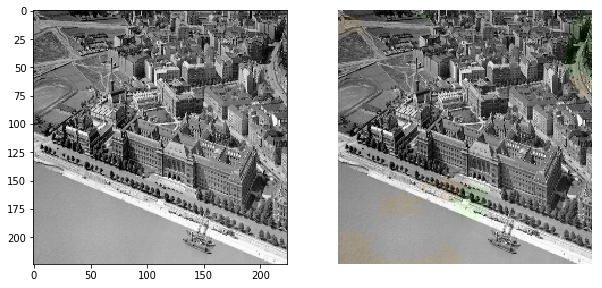

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


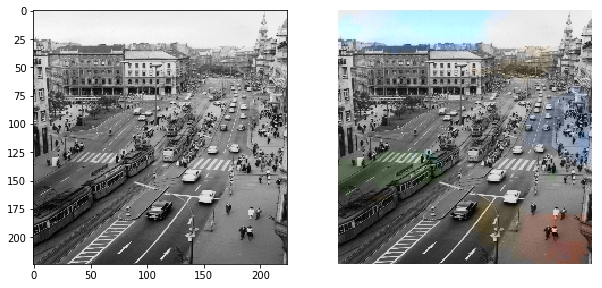

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


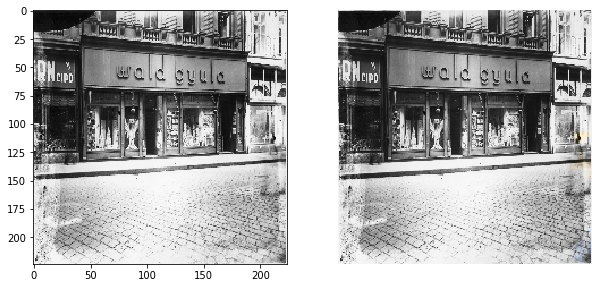

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


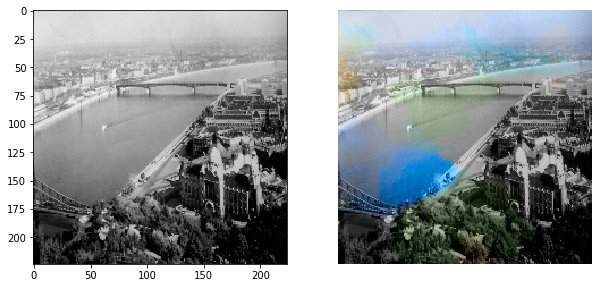

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


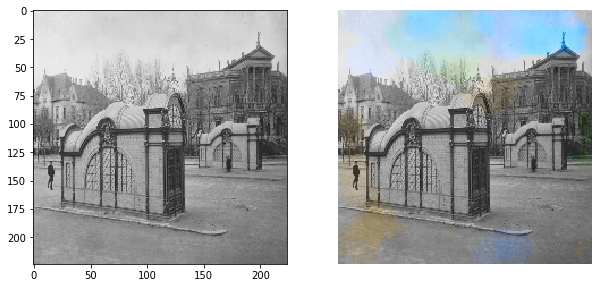

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


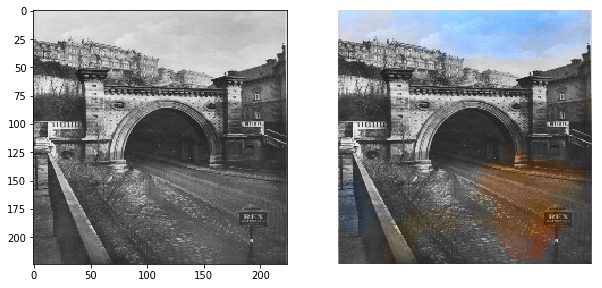

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


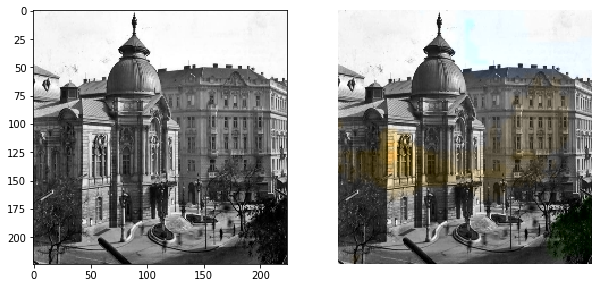

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


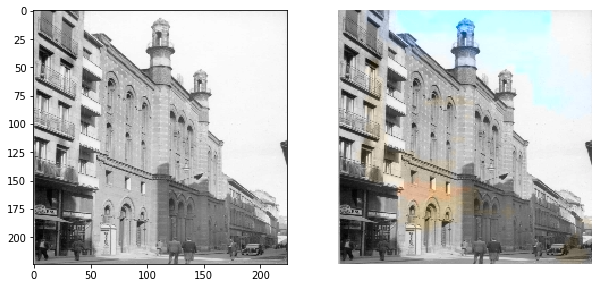

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


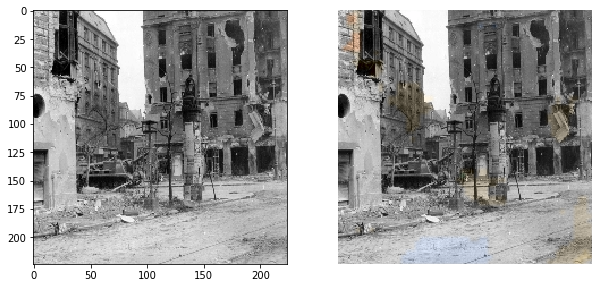

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


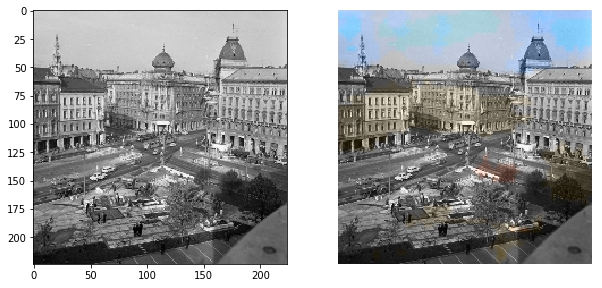

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


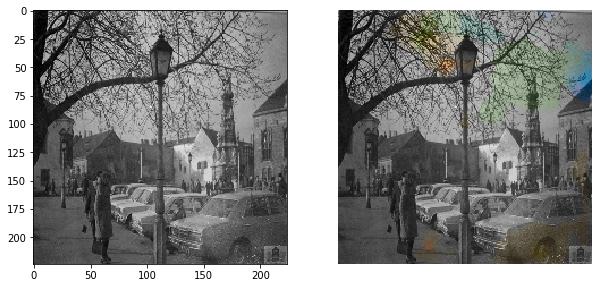

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


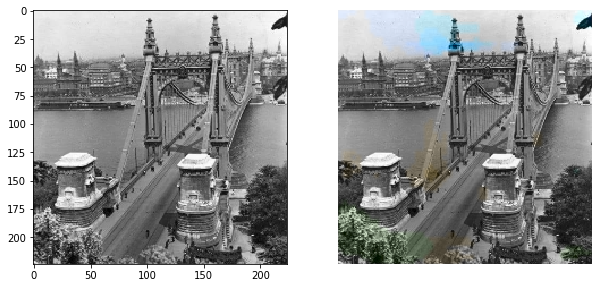

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


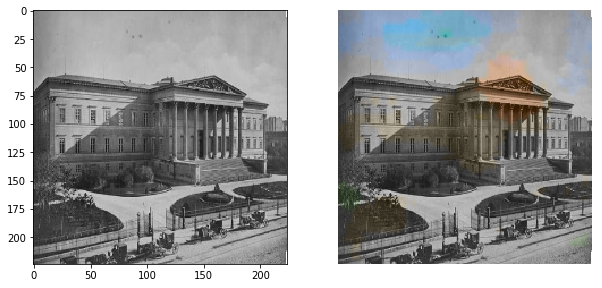

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 29 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


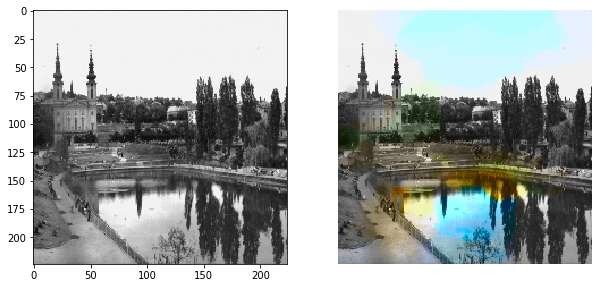

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


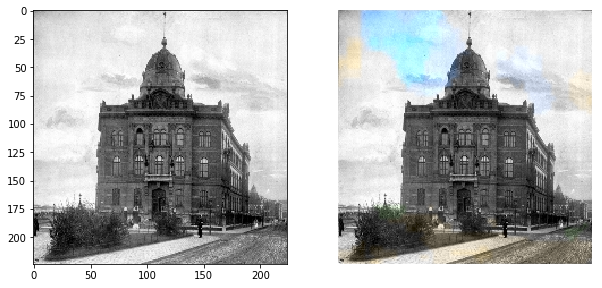

In [40]:
from matplotlib.pyplot import imshow
from skimage import color
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import transform, io, color

from importlib import reload  # Python 3.4+ only.
import streaming_data
streaming_data = reload(streaming_data)

watcher = streaming_data.StreamingDataGenerator(image_folder,batch_size=1, random_trf= False)

for idx in range(len(watcher)):
    X,Y = watcher[idx]
    fig, ax= plt.subplots(1,2,figsize=(10, 10)) 
    plt.axis('off')
    ax[0].imshow(watcher.gray_img[0]/255)
    
    rgb_img = conc_pred(model, X, watcher)
    plt.axis('off')
    ax[1].imshow(rgb_img)
    plt.savefig(root_pictures + 'test_img'+str(idx)+'.png', bbox_inches='tight')
    plt.show()
    

In [63]:
def create_plothistory(log_folder, save_location = None):
    history = pd.read_csv(log_folder)
    
    plt.figure()
    plt.plot(history['epoch'], history['acc']*100)
    plt.plot(history['epoch'], history['val_acc']*100)
    plt.title('model accuracy')
    plt.ylabel('accuracy in percent')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    if (save_location is not None):
        plt.savefig(save_location + 'model_accuracy.png')
    plt.show()
    
    plt.figure()
    # summarize history for loss
    plt.plot(history['epoch'], history['loss'])
    plt.plot(history['epoch'], history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    if (save_location is not None):
        plt.savefig(save_location + 'model_loss.png')
    plt.show() 

In [64]:
create_plothistory(log_path, saveplot_folder)

FileNotFoundError: File b'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/2/training1.log' does not exist

Image subplot gallery creation

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\keras_preprocessing\image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Length of image list:  15


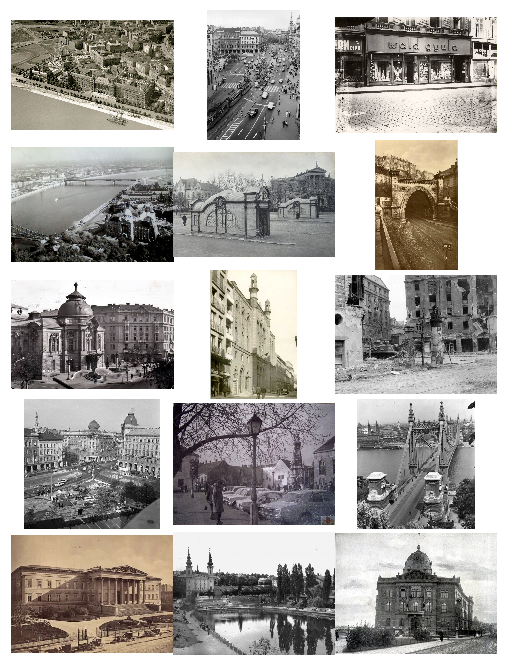

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

nrow = 2
ncol = 3
fig = plt.figure(figsize=(10, 10)) 

watcher = streaming_data.StreamingDataGenerator(image_folder,batch_size=1, random_trf= False)
gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1],
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 

for i in range(nrow):
    for j in range(ncol):
        im = watcher.image_list[i*3+j]
        ax= plt.subplot(gs[i,j])
        ax.axis('off')
        ax.imshow(im/255)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

#plt.tight_layout() # do not use this!!
plt.savefig(root_pictures+ 'legacy_image_gallery.png')
plt.show()